# Classification Images in black and white (MASK) with CNN model using pytoch

# The results in this code was good

### Pytorch
PyTorch is a popular open-source deep learning framework developed by Facebook's AI Research lab (FAIR). It provides a flexible and intuitive interface for building and training neural networks. With PyTorch, users can easily create computational graphs dynamically, enabling more efficient model development and experimentation. It also offers seamless integration with GPUs for accelerated computation, making it suitable for both research and production-level machine learning tasks. PyTorch's extensive library includes modules for building various types of neural networks, optimization algorithms, and utilities for data loading and preprocessing. 

In [4]:
#Import all the libraries needed in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import shutil
import random
import tensorflow as tf
import torch
#import statsmodels.api as sm

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
'''# Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Import tensorflow libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
'''
#Import torch libraries
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [8]:
# Imposta il seed per PyTorch per rendere i risultati riproducibili
seed = 87
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None

# Imposta il seed per NumPy per rendere i risultati riproducibili
np.random.seed(seed)

# Imposta il seed per la libreria random di Python per rendere i risultati riproducibili
random.seed(seed)

In [5]:
# defining images dimensions
img_height = 512
img_width = 512
batch_size = 15

In [6]:
# Trasforming images of validation and training sets
train_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.Grayscale(),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Uploading dataset
train_dataset = datasets.ImageFolder(root='dataset/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='dataset/val', transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root='dataset/test', transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

This code defines the transformations to be applied to images in the training set and the validation/test set before being used for training or evaluating the deep learning model. Here's an explanation of the transformations:

- `transforms.Resize((img_height, img_width))`: Resizes the images to the specified dimensions `img_height` for height and `img_width` for width.

- `transforms.Grayscale()`: Converts the images to grayscale. This reduces the number of channels in the image from 3 (RGB) to 1 (grayscale).

- `transforms.RandomRotation(20)`: Randomly rotates the image by a maximum angle of 20 degrees clockwise or counterclockwise.

- `transforms.RandomHorizontalFlip()`: Applies a random horizontal flip transformation to the image with a probability of 50%.

- `transforms.RandomVerticalFlip()`: Applies a random vertical flip transformation to the image with a probability of 50%.

- `transforms.ToTensor()`: Converts the image to a PyTorch tensor.

- `transforms.Normalize(mean=[0.5], std=[0.5])`: Normalizes the pixel values of the image by subtracting the mean [0.5] and dividing by the standard deviation [0.5].

The transformations for the validation/test set are similar, but they do not include random rotation and flip transformations, as we want to evaluate the model on unmodified images.

In [6]:
# Definition of CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * (img_height // 16) * (img_width // 16), 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 256 * (img_height // 16) * (img_width // 16))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

This code defines a simple Convolutional Neural Network (CNN) architecture in PyTorch for binary classification. Here's an explanation of each part of the code:

- **SimpleCNN(nn.Module)**: Defines a `SimpleCNN` class that inherits from the `nn.Module` class, the base class for all PyTorch models.

- **__init__(self)**: Called when an object of the `SimpleCNN` class is instantiated. Within this method, all the layers of the neural network are defined and initialized.

- **self.conv1**: First convolutional layer that takes grayscale images (1 channel) as input and produces 32 output feature maps. It uses a 3x3 kernel with padding of 1.

- **self.pool**: Max pooling layer with a pooling window size of 2x2 and a stride of 2. This reduces the size of the input feature maps.

- **self.conv2**: Second convolutional layer that takes the feature maps produced by the first layer (32 feature maps) as input and produces 64 output feature maps.

- **self.conv3**: Third convolutional layer that takes the feature maps produced by the second layer (64 feature maps) as input and produces 128 output feature maps.

- **self.conv4**: Fourth convolutional layer that takes the feature maps produced by the third layer (128 feature maps) as input and produces 256 output feature maps.

- **self.fc1**: First fully connected layer that takes the flattened feature map vector as input and returns a vector of size 512.

- **self.fc2**: Second fully connected layer that takes the 512-dimensional vector produced by the first fully connected layer as input and returns a vector of size 128.

- **self.fc3**: Third fully connected layer that takes the 128-dimensional vector produced by the second fully connected layer as input and returns a single output value (1) using the sigmoid activation function.

- **forward(self, x)**: Defines the flow of data through the neural network. It takes x, representing the input image, and passes it through the various layers of the network in sequence.

The code uses the *ReLU* activation function for the convolutional layers and the first two fully connected layers, and the sigmoid activation function for the final fully connected layer, as it is a binary classification task.
The network defined is moderate size, comprising a total of four convolutional layers followed by three fully connected layers.

In [7]:

model = SimpleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


**SimpleCNN**: The variable model is initialized as an instance of the SimpleCNN class, which represents the convolutional neural network architecture defined earlier. It's called "simple" because it's a straightforward architecture without too many complexities.

**nn.BCELoss()**: This is the binary cross-entropy loss function provided by PyTorch's neural network module (nn). It's commonly used for binary classification tasks, where the model outputs a single scalar value representing the probability of the positive class. BCE stands for Binary Cross-Entropy.

**optim.Adam(model.parameters()**, **lr=0.001)**: This line initializes the Adam optimizer, which is a popular optimization algorithm used for training neural networks. It's called on the parameters of the model, meaning it will update the weights of the network during training to minimize the loss. lr=0.001 sets the learning rate to 0.001, which controls the step size of the optimizer.

In [8]:
#Function for training the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels.float())
                running_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = correct / total
        val_loss_history.append(epoch_loss)
        val_acc_history.append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss_history[-1]:.4f}, Train Acc: {train_acc_history[-1]:.4f}, '
              f'Val Loss: {val_loss_history[-1]:.4f}, Val Acc: {val_acc_history[-1]:.4f}')
    
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


# Function to Train the Model

This function is used to train a neural network model using the provided training and validation datasets. Here's a breakdown of its components:

- **Inputs**:
  - `model`: The neural network model to be trained.
  - `train_loader`: DataLoader containing the training dataset.
  - `val_loader`: DataLoader containing the validation dataset.
  - `criterion`: The loss function used for training.
  - `optimizer`: The optimization algorithm used for updating the model parameters.
  - `num_epochs` (default: 20): The number of training epochs.

- **Training Loop**:
  - The function iterates over each epoch and within each epoch, it iterates over batches of data from the training loader.
  - It performs a forward pass through the model, computes the loss, calculates gradients, and updates the model parameters using the optimizer.
  - It also computes training loss and accuracy for each epoch.

- **Validation Loop**:
  - After each training epoch, the function evaluates the model on the validation dataset to compute validation loss and accuracy.
  - The model is set to evaluation mode during validation to disable features like dropout.
  
- **Print Statements**:
  - Information such as epoch number, training loss, training accuracy, validation loss, and validation accuracy is printed for each epoch.

- **Return Values**:
  - Returns lists containing the training and validation loss and accuracy values for each epoch.


In [9]:
# training the model
train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Epoch 1/20, Train Loss: 0.6499, Train Acc: 0.6327, Val Loss: 0.5520, Val Acc: 0.7812
Epoch 2/20, Train Loss: 0.5370, Train Acc: 0.7478, Val Loss: 0.5284, Val Acc: 0.7500
Epoch 3/20, Train Loss: 0.5064, Train Acc: 0.7566, Val Loss: 0.4919, Val Acc: 0.7604
Epoch 4/20, Train Loss: 0.5193, Train Acc: 0.7478, Val Loss: 0.5894, Val Acc: 0.7396
Epoch 5/20, Train Loss: 0.5494, Train Acc: 0.7146, Val Loss: 0.5093, Val Acc: 0.7708
Epoch 6/20, Train Loss: 0.5080, Train Acc: 0.7345, Val Loss: 0.4647, Val Acc: 0.7812
Epoch 7/20, Train Loss: 0.4724, Train Acc: 0.7920, Val Loss: 0.4723, Val Acc: 0.7500
Epoch 8/20, Train Loss: 0.4712, Train Acc: 0.7965, Val Loss: 0.7130, Val Acc: 0.5625
Epoch 9/20, Train Loss: 0.4779, Train Acc: 0.7942, Val Loss: 0.4017, Val Acc: 0.8229
Epoch 10/20, Train Loss: 0.4117, Train Acc: 0.8230, Val Loss: 0.4483, Val Acc: 0.7917
Epoch 11/20, Train Loss: 0.4215, Train Acc: 0.8385, Val Loss: 0.3787, Val Acc: 0.8229
Epoch 12/20, Train Loss: 0.3655, Train Acc: 0.8606, Val Loss: 0

# Accuracy and Loss through the epochs

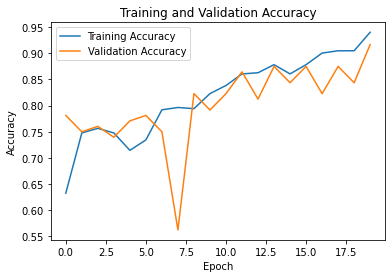

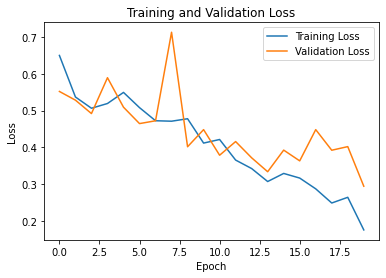

In [10]:
# Plotting training and validation accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Interpretation of Training and Validation Accuracy and Loss Graphs

### Accuracy:

- **Training Accuracy (Blue Line)**: Shows how the model's accuracy on the training set improves over time. There is an upward trend, which is a good sign.
- **Validation Accuracy (Orange Line)**: Shows how the model's accuracy on the validation set varies over time. Despite fluctuations, there is a general improving trend.

### Loss:

- **Training Loss (Blue Line)**: Shows how the loss on the training set decreases over time, indicating that the model is learning.
- **Validation Loss (Orange Line)**: Shows how the loss on the validation set varies over time. Despite fluctuations, there is a general decreasing trend.

### Overfitting Indications:

- **Difference between Training and Validation Accuracy**: If training accuracy keeps improving while validation accuracy stabilizes or worsens, it could indicate overfitting. In this graph, validation accuracy does not show a significant decline, suggesting overfitting might not be a severe issue.
- **Difference between Training and Validation Loss**: If training loss consistently decreases while validation loss does not follow the same trend (e.g., validation loss starts to increase), it could indicate overfitting. Here, validation loss fluctuates but shows a general decreasing trend, suggesting overfitting might not be significant.


# Metrics: sensitivity, specificity, accuracy, confusion matrics

In [11]:

def calculate_metrics(model, loader, threshold=0.5):
    model.eval()
    true_labels = []
    pred_labels = []
    probabilities = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs).squeeze()
            probabilities.extend(outputs.tolist())
            predicted = (outputs > threshold).float()
            true_labels.extend(labels.tolist())
            pred_labels.extend(predicted.tolist())
    
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    probabilities = np.array(probabilities)
    
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    accuracy = accuracy_score(true_labels, pred_labels)
    sensitivity = recall_score(true_labels, pred_labels)
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    kappa = cohen_kappa_score(true_labels, pred_labels)
    fpr, tpr, _ = roc_curve(true_labels, probabilities)
    roc_auc = auc(fpr, tpr)
    
    return conf_matrix, accuracy, sensitivity, specificity, kappa, fpr, tpr, roc_auc

In [12]:
# metrics on training
train_conf_matrix, train_accuracy, train_sensitivity, train_specificity, train_kappa, train_fpr, train_tpr, train_roc_auc = calculate_metrics(model, train_loader)

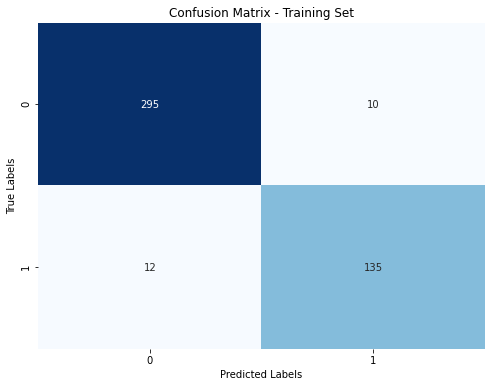

In [13]:
# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Training Set')
plt.show()

### The confusion matrix on training set is very good!

In [14]:
# Print evaluation metrics
print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Sensitivity (Recall): {train_sensitivity:.4f}")
print(f"Specificity: {train_specificity:.4f}")
print(f"Cohen's Kappa: {train_kappa:.4f}")

Training Set Metrics:
Accuracy: 0.9513
Sensitivity (Recall): 0.9184
Specificity: 0.9672
Cohen's Kappa: 0.8887


### Also the metrics on training are good!

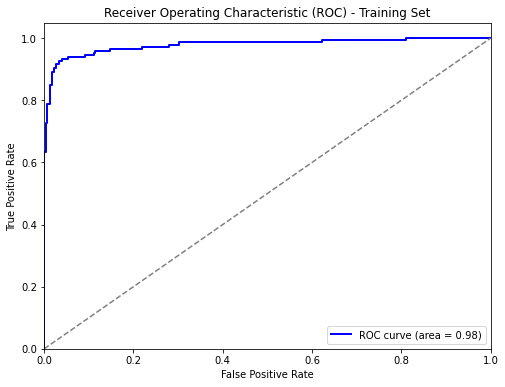

In [15]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'ROC curve (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Training Set')
plt.legend(loc='lower right')
plt.show()

### Good roc curve

# Metrics on test set

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

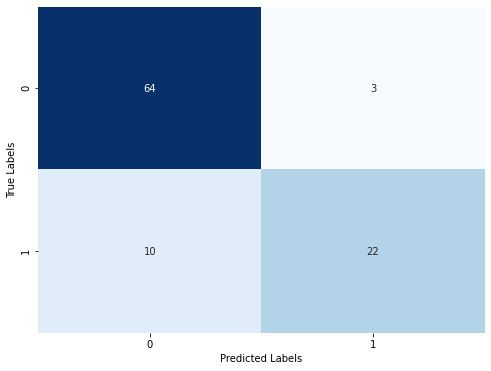

In [16]:
# Calcolo delle metriche sul test set
test_conf_matrix, test_accuracy, test_sensitivity, test_specificity, test_kappa, test_fpr, test_tpr, test_roc_auc = calculate_metrics(model, test_loader)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title

In [17]:
# Print evaluation metrics
print("Test Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Sensitivity (Recall): {test_sensitivity:.4f}")
print(f"Specificity: {test_specificity:.4f}")
print(f"Cohen's Kappa: {test_kappa:.4f}")

Test Set Metrics:
Accuracy: 0.8687
Sensitivity (Recall): 0.6875
Specificity: 0.9552
Cohen's Kappa: 0.6817


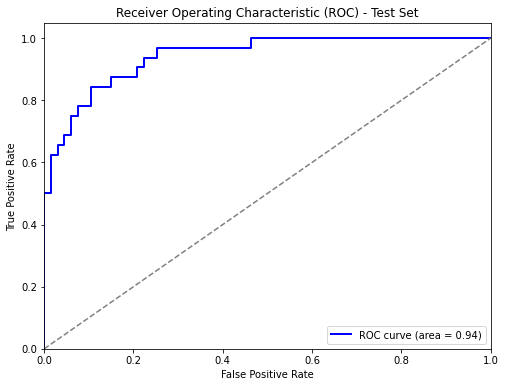

In [18]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label=f'ROC curve (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Test Set')
plt.legend(loc='lower right')
plt.show()

### The metrics on the test set are very positive! This neural network has successfully classified the black and white MASK images profitably.